In [2]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using ForwardDiff;

In [4]:
#Hyperparameters
n = 20
N = 80
σₐ = 0.002
k_range = 12
k_list = [i for i in 1:k_range];

In [5]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

function sigmoid(x::Array{Float64}, a=10)
    return 1.0 ./ (1.0 .+ a.*exp.(-x))
end

function sigmoid(x::Float64, a=10)
    return 1.0/(1.0 + a*exp(-x))
end

mₖ(k) = k*4 + 1;

mₖ (generic function with 1 method)

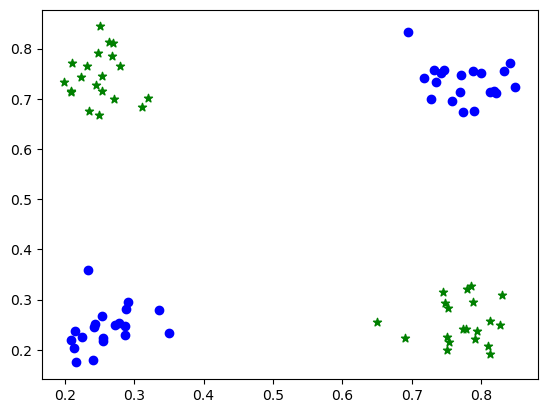

In [6]:
#Generate XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.25, 0.75]
    μ₃ = [0.75, 0.75]
    μ₄ = [0.75, 0.25]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

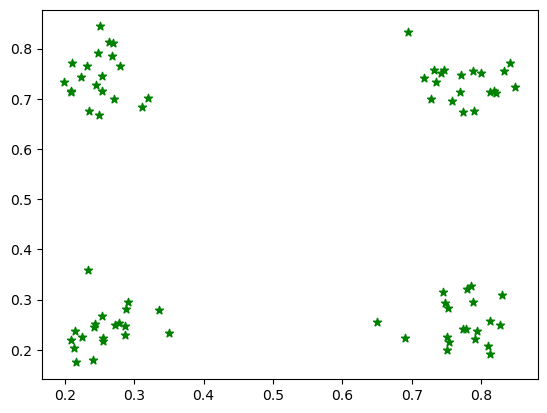

In [7]:
#Bayesian Neural Net
function G(x, Θ::AbstractVector, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    W₁, b₁, W₂, b₂ = unpack(Θ,k)
    nn = Chain(Dense(W₁, b₁, σ),
               Dense(W₂, [b₂]))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

@gen function classifier(x::Array{Float64})
    σₖ = 100.0::Float64
    
    k ~ uniform_discrete(1,k_range) #Number of hidden nodes
    #k ~ k_count(1,0.5,1) #Shifted Negative Binomial
    #println(k)
    
    # Create the weight and bias vector.
    m = mₖ(k)
    μ = zeros(m)
    Σ = Diagonal([σₖ for i=1:m])
    Θ ~ mvnormal(μ,Σ) #Coefficients of the polynomial
    
    #Return Network Scores for X
    scores = Flux.σ.(G(x,Θ,k))
    
    #Logistic Regression Likelihood
    y = zeros(length(x[1,:])) #Array to fill with class labels
    for j=1:N
        y[j] = @trace(normal(scores[j]*1 + (1-scores[j])*0, 0.05), (:y,j))
    end
    return scores
    
end;

predictions = classifier(data)
preds = data_labeller(predictions)
plot_data(data_raw,preds)

In [8]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
for j in 1:length(classes)
    obs_master[(:y, j)] = classes[j] - 1
end;
obs = obs_master;

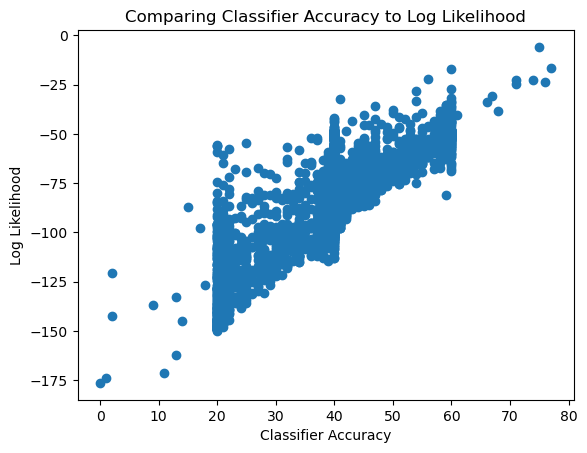

In [9]:
#Plot of Log Likelihood Scores
scores = []
accs = []
ks = []
(best_trace,) = generate(classifier, (data,), obs)
best_score = get_score(best_trace)/length(classes)
best_Θ = best_trace[:Θ]
best_k = best_trace[:k]

best_pred_y = G(data,best_Θ,best_k)
best_pred_labels = data_labeller(best_pred_y)
best_acc = sum([best_trace[(:y,i)] == best_pred_labels[i] for i=1:length(classes)])/length(classes)

for i in 1:10000
    (trace,) = generate(classifier, (data,), obs)
    
    Θ = trace[:Θ]
    k = trace[:k]
    pred_y = G(data,Θ,k)
    pred_labels = data_labeller(pred_y)

    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    score = get_score(trace)/length(classes)
    if acc > best_acc
        best_score = score
        best_trace = trace
        best_acc = acc
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
end

scatter(accs,scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");

In [25]:
traces = []
acc = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Θ), L=10, eps=0.02, check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
    end
    return trace
end

function across_dimension2(trace, iters, obs)
    selection = select(:Θ,:k)
    
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    (new_trace, weight) = regenerate(trace, args, argdiffs, selection)
    
    for i=1:20
        (new_trace, accepted) = hmc(new_trace, select(:Θ), L=3, eps=0.02, check=false, observations=obs)
        #accepted && println("It's working!")
    end
    
    score1 = exp(get_score(trace)/length(data))
    score2 = exp(get_score(new_trace)/length(data))
    score = score2/score1
    println(score)
    
    if rand(Uniform(0,1)) < 1
        accepted = true
        trace = new_trace
        #new_k = obs[:k]
        #println("New k accepted! Current k: $(new_k)")
        push!(acc,true)
    else
        accepted = false
        obs = obs_master
        obs[:k] = previous_k
        push!(acc,false)
    end
        
    push!(traces, trace)
    push!(acc, accepted)
    return trace, trace[:k]
end

function across_dimension(trace, iters, previous_k)
    score1 = exp(get_score(trace)/length(data))
    obs = obs_master
    #(trace, accepted) = mh(trace, select(:k), check=false, observations=obs)
    (choices, _, _) = propose(classifier, (data,))
    obs[:k] = choices[:k]
    new_trace = trace
    #(new_trace,) = generate(classifier, (data,0), obs)
    
    for i=1:20
        (new_trace, _) = hmc(trace, select(:Θ), L=3, eps=0.02, check=false, observations=obs)
    end
    
    score2 = exp(get_score(new_trace)/length(data))
    println(obs[:k])
    
    score = score2/score1
    
    if score > 1
        accepted = true
    else
        if score > rand(Uniform(0,1))
            accepted = true
        else
            accepted = false
        end
    end
    
    if accepted == true
        trace = new_trace
        new_k = obs[:k]
        println("New k accepted! Current k: $(new_k)")
        push!(acc,true)
    else
        obs = obs_master
        obs[:k] = previous_k
        push!(acc,false)
    end
    
    push!(traces,trace)
    
    return trace, obs[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    for i = 1:iters
        if i%5000 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
        end
        
        if rand(Uniform(0,1)) > 0.99
            (trace, k) = across_dimension2(trace, 1, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
       
end
    
(starting_trace,) = generate(classifier, (data,), obs)
obs[:k] = best_trace[:k]
rjmcmc(starting_trace,1000);

Beginning RJMCMC. Starting k: 8
0.9714467873380473
2.0272426223553837e-22
2.0006197967380275
6.663348577686646e9
7.350203354717918e-15
0.5198438669204726
1.578382328610662
0.811070728741008
1.3448765362322055e-11
1.9567634113480747e-17


InterruptException: InterruptException:

In [18]:
sizes = [length(trace[:Θ]) for trace in traces]

10000-element Array{Int64,1}:
 33
 33
 33
 33
 33
 33
 33
 33
 33
 33
 33
 33
 33
  ⋮
 29
 29
 29
 29
 29
 29
 29
 29
 29
 29
 29
 29

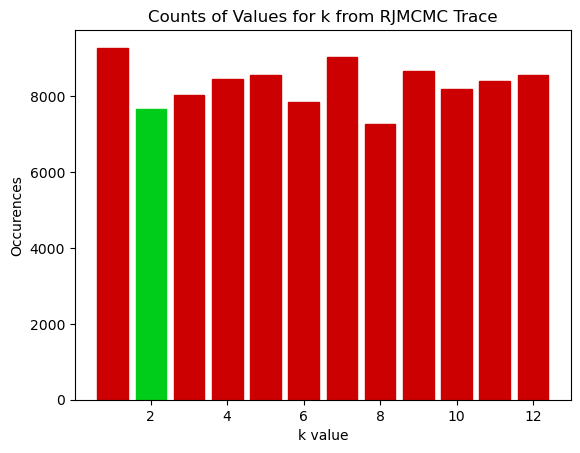

In [21]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

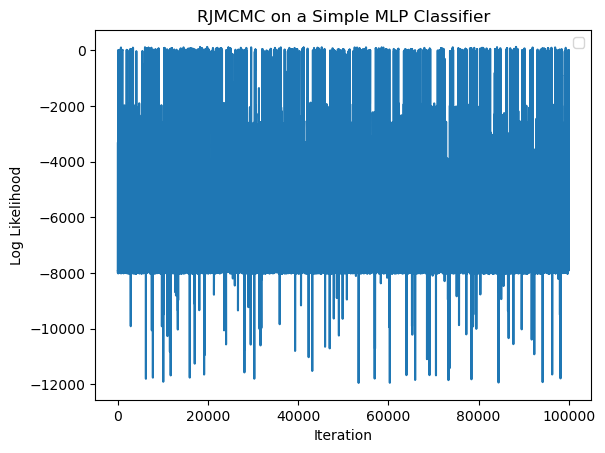

No handles with labels found to put in legend.


In [22]:
#hmc_traces_master = vcat(hmc_traces, hmc_traces2, hmc_traces3, hmc_traces4);
scores = [get_score(i) for i in traces]
plot(scores)
plt.title("RJMCMC on a Simple MLP Classifier")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
#plt.axvline(100,label="Burn-In: ~1000",color="red")
plt.legend();

In [ ]:
obs2 = get_choices(best_trace)
(trace,) = generate(classifier, (data, obs2[:k]), obs2)
test = get_arg_diffs(trace)
#(trace,_,_) = regenerate(best_trace, (data, obs2[:k]))

In [ ]:
(trace,) = generate(classifier, (data,), obs)
tests = []
#println(trace[:k])
for i=1:30
    (trace, accepted) = mh(trace, select(:Θ,:k), check=false, observations=obs)
    print(length(trace[:Θ]))
    push!(tests,trace)
end
lengths = [length(trace[:Θ]) for trace in tests]